Digits dataset resized and prepared. Training samples: 1437, Validation samples: 360
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:46<00:00, 213382.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 42529.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:08<00:00, 193536.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8497113.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training on Digits Dataset:
Epoch 1/10, Train Loss: 0.8623
Epoch 2/10, Train Loss: 0.1844
Epoch 3/10, Train Loss: 0.1013
Epoch 4/10, Train Loss: 0.0716
Epoch 5/10, Train Loss: 0.0550
Epoch 6/10, Train Loss: 0.0423
Epoch 7/10, Train Loss: 0.0219
Epoch 8/10, Train Loss: 0.0081
Epoch 9/10, Train Loss: 0.0091
Epoch 10/10, Train Loss: 0.0243
Training on MNIST Dataset:
Epoch 1/10, Train Loss: 0.1169
Epoch 2/10, Train Loss: 0.0385
Epoch 3/10, Train Loss: 0.0232
Epoch 4/10, Train Loss: 0.0148
Epoch 5/10, Train Loss: 0.0112
Epoch 6/10, Train Loss: 0.0086
Epoch 7/10, Train Loss: 0.0069
Epoch 8/10, Train Loss: 0.0060
Epoch 9/10, Train Loss: 0.0038
Epoch 10/10, Train Loss: 0.0063
Evaluating Digits Model on MNIST Test Set:
Test Accuracy: 9.82%
Evaluating MNIST Model on MNIST Test Set:
Test Accuracy: 98.96%


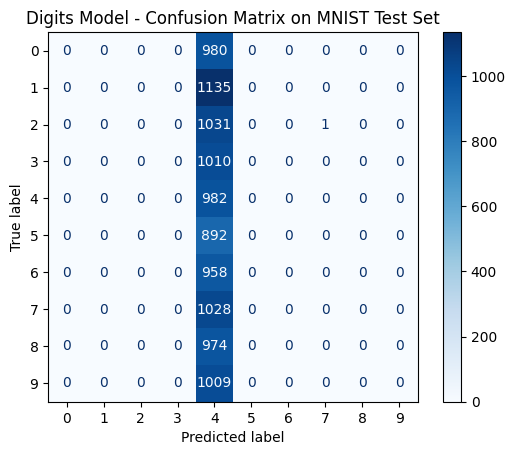

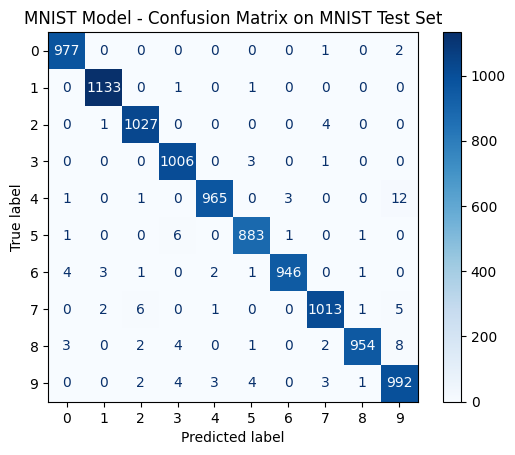

In [4]:
import torch
from torchvision import transforms, datasets as torch_datasets
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import random
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set the seed for reproducibility

# Load the Digits Dataset from sklearn
digits = datasets.load_digits()
X_digits, y_digits = digits.data, digits.target

# Scale the digits dataset to 0-1 range (similar to MNIST normalization)
scaler = MinMaxScaler()
X_digits = scaler.fit_transform(X_digits)

# Reshape the digits dataset from (1797, 64) to (1797, 8, 8)
X_digits = X_digits.reshape(-1, 8, 8)

# Resize each 8x8 image to 28x28 using scipy's zoom function
zoom_factor = 28 / 8  # Calculate zoom factor
X_digits_resized = np.array([zoom(img, zoom_factor) for img in X_digits])  # Shape: (1797, 28, 28)

# Convert to PyTorch tensors and add the channel dimension
X_digits_resized = torch.tensor(X_digits_resized).unsqueeze(1).float()  # Shape: (1797, 1, 28, 28)
y_digits = torch.tensor(y_digits).long()

# Create training and validation sets for the digits dataset
train_size = int(0.8 * len(X_digits_resized))
valid_size = len(X_digits_resized) - train_size
digits_train_dataset, digits_valid_dataset = random_split(
    TensorDataset(X_digits_resized, y_digits), [train_size, valid_size])

# Create data loaders for digits dataset
train_loader_digits = DataLoader(digits_train_dataset, batch_size=32, shuffle=True)
valid_loader_digits = DataLoader(digits_valid_dataset, batch_size=32, shuffle=False)

print(f"Digits dataset resized and prepared. Training samples: {train_size}, Validation samples: {valid_size}")

# Step 1: Load and Prepare MNIST Dataset from torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load MNIST dataset only if not already present
if not os.path.exists('./data/MNIST/raw'):
    train_mnist = torch_datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_mnist = torch_datasets.MNIST(root='./data', train=False, download=True, transform=transform)
else:
    train_mnist = torch_datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    test_mnist = torch_datasets.MNIST(root='./data', train=False, download=False, transform=transform)

# Create data loaders for MNIST dataset
train_loader_mnist = DataLoader(train_mnist, batch_size=32, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=32, shuffle=False)

# Step 2: Define the CNN Model (for both datasets)
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Train the Model Function
def train_model(model, criterion, optimizer, train_loader, epochs=10, model_name="model.pth"):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), model_name)
    print(f"Model saved as '{model_name}'")

    return train_losses

# Step 4: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return y_true, y_pred

# Step 5: Train on Digits Dataset
print("Training on Digits Dataset:")
model_digits = DigitCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_digits.parameters(), lr=0.001)
train_model(model_digits, criterion, optimizer, train_loader_digits, epochs=10, model_name="digits_model.pth")

# Step 6: Train on MNIST Dataset
print("Training on MNIST Dataset:")
model_mnist = DigitCNN()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)
train_model(model_mnist, criterion, optimizer, train_loader_mnist, epochs=10, model_name="mnist_model.pth")

# Step 7: Evaluate Both Models on the MNIST Test Set
print("Evaluating Digits Model on MNIST Test Set:")
model_digits.load_state_dict(torch.load("digits_model.pth"))  # Load saved model
y_true_digits, y_pred_digits = evaluate_model(model_digits, test_loader_mnist)

print("Evaluating MNIST Model on MNIST Test Set:")
model_mnist.load_state_dict(torch.load("mnist_model.pth"))  # Load saved model
y_true_mnist, y_pred_mnist = evaluate_model(model_mnist, test_loader_mnist)

# Step 8: Confusion Matrix for Both Models
cm_digits = confusion_matrix(y_true_digits, y_pred_digits)
disp_digits = ConfusionMatrixDisplay(confusion_matrix=cm_digits, display_labels=range(10))
disp_digits.plot(cmap=plt.cm.Blues)
plt.title("Digits Model - Confusion Matrix on MNIST Test Set")
plt.show()

cm_mnist = confusion_matrix(y_true_mnist, y_pred_mnist)
disp_mnist = ConfusionMatrixDisplay(confusion_matrix=cm_mnist, display_labels=range(10))
disp_mnist.plot(cmap=plt.cm.Blues)
plt.title("MNIST Model - Confusion Matrix on MNIST Test Set")
plt.show()
